## Setup

###Installing dependencies

In [ ]:
! pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 21.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=2fe55169418e706ae8c74bfb7968fe817e72d9d2d2da8871c5efe7b6c3f600f9
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark


###Connecting GDrive

In [ ]:
from google.colab import drive
drive.mount("/content/gDrive")

Mounted at /content/gDrive


###Importing dependencies

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from pyspark import SparkContext
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer,OneHotEncoder, StringIndexer, VectorAssembler,HashingTF, IDF
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import seaborn as sns

##Spark session

In [ ]:
spark = SparkSession.builder.appName('Multi-Class Text Classification').getOrCreate()

## Data Opeartions

###Loding the data

In [ ]:
path="/content/gDrive/MyDrive/Datasets/text_data/bbc-text.csv"
data = spark.read.csv(path, header=True, inferSchema=True)

In [ ]:
data.printSchema()

root
 |-- category: string (nullable = true)
 |-- text: string (nullable = true)



In [ ]:
data.columns

['category', 'text']

In [ ]:
pd.DataFrame(data.take(5), columns=data.columns)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
data.groupBy("category").count().orderBy(col("count").desc()).show()

+-------------+-----+
|     Category|count|
+-------------+-----+
|        sport|  511|
|     business|  510|
|     politics|  417|
|         tech|  401|
|entertainment|  386|
+-------------+-----+



### Preprocessing

In [ ]:
# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")

In [ ]:
# stop words
add_stopwords = ["http","https","amp","rt","t","c","the"] # standard stop words

stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

### Feature Enginnering

In [ ]:
# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

In [ ]:
label_stringIdx = StringIndexer(inputCol = "category", outputCol = "label")

### Creating pipeline

In [ ]:
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

# Fit the pipeline to training documents.
training = pipeline.fit(data)
dataset = training.transform(data)

In [ ]:
dataset.show(5)

+-------------+--------------------+--------------------+--------------------+--------------------+-----+
|     category|                text|               words|            filtered|            features|label|
+-------------+--------------------+--------------------+--------------------+--------------------+-----+
|         tech|tv future in the ...|[tv, future, in, ...|[tv, future, in, ...|(9445,[0,1,2,3,4,...|  3.0|
|     business|worldcom boss  le...|[worldcom, boss, ...|[worldcom, boss, ...|(9445,[0,1,2,3,4,...|  1.0|
|        sport|tigers wary of fa...|[tigers, wary, of...|[tigers, wary, of...|(9445,[0,1,2,3,4,...|  0.0|
|        sport|yeading face newc...|[yeading, face, n...|[yeading, face, n...|(9445,[0,1,2,3,4,...|  0.0|
|entertainment|ocean s twelve ra...|[ocean, s, twelve...|[ocean, s, twelve...|(9445,[0,1,2,3,4,...|  4.0|
+-------------+--------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



###Preparing data for ML model

In [ ]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 1550
Test Dataset Count: 675


###Feature Engineering using TF-ID

In [ ]:
# Add HashingTF and IDF to transformation
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

###Creating pipeline for TF-ID

In [ ]:
pipeline_TF = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF, idf, label_stringIdx])
train_TF = pipeline_TF.fit(data)
dataset_TF = train_TF.transform(data)

###Preparing data for ML model with TF-ID

In [ ]:
(trainingData_TF, testData_TF) = dataset_TF.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData_TF.count()))
print("Test Dataset Count: " + str(testData_TF.count()))

Training Dataset Count: 1550
Test Dataset Count: 675


##Model building

###Base model



In [ ]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lr_train = lr.fit(trainingData)
predictions = lr_train.transform(testData)

In [ ]:
lr_train_TF = lr.fit(trainingData_TF)
predictions_TF = lr_train_TF.transform(testData_TF)

### Predictions

In [ ]:
predictions

DataFrame[category: string, text: string, words: array<string>, filtered: array<string>, features: vector, label: double, rawPrediction: vector, probability: vector, prediction: double]

In [ ]:
predictions.filter(predictions['prediction'] == 1).select("text","category","probability","label","prediction").orderBy("probability", ascending=False).show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                          text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|glazer makes new man utd ap...|business|[0.19704857265986547,0.6156...|  1.0|       1.0|
|insurance bosses plead guil...|business|[0.17965642764229942,0.6164...|  1.0|       1.0|
|gsk aims to stop aids profi...|business|[0.164759317830061,0.422673...|  1.0|       1.0|
|russia wto talks  make prog...|business|[0.15617913233636097,0.4328...|  1.0|       1.0|
|jp morgan admits us slavery...|business|[0.14205628992160146,0.5606...|  1.0|       1.0|
|quiksilver moves for rossig...|business|[0.13542440890690766,0.6974...|  1.0|       1.0|
|qatar and shell in $6bn gas...|business|[0.12586040580731306,0.7327...|  1.0|       1.0|
|iraq to invite phone licenc...|business|[0.12470222468663826,0.6080...|  1.0|       1.0|
|tate & ly

In [ ]:
predictions_TF.filter(predictions_TF['prediction'] == 1) \
    .select("text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                          text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|qatar and shell in $6bn gas...|business|[0.2828572526032937,0.48328...|  1.0|       1.0|
|insurance bosses plead guil...|business|[0.22977397339345823,0.5239...|  1.0|       1.0|
|quiksilver moves for rossig...|business|[0.2172497171426907,0.63072...|  1.0|       1.0|
|stormy year for property in...|business|[0.2055608152250655,0.45960...|  1.0|       1.0|
|executive trio leave aer li...|business|[0.1880614976109774,0.39560...|  1.0|       1.0|
|russia wto talks  make prog...|business|[0.17742410304527462,0.5104...|  1.0|       1.0|
|glazer makes new man utd ap...|business|[0.17647856964295097,0.6049...|  1.0|       1.0|
|gsk aims to stop aids profi...|business|[0.17542817495291388,0.5198...|  1.0|       1.0|
|umbro pro

### Evaluation

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.9688624452757706

In [ ]:
evaluator.evaluate(predictions_TF)

0.9614406618744511

In [ ]:
predictions.groupBy("prediction").count().orderBy(col("count").desc()).show()

+----------+-----+
|prediction|count|
+----------+-----+
|       1.0|  159|
|       0.0|  158|
|       3.0|  123|
|       2.0|  122|
|       4.0|  113|
+----------+-----+



In [ ]:
predictions_TF.groupBy("prediction").count().orderBy(col("count").desc()).show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  158|
|       1.0|  158|
|       3.0|  123|
|       2.0|  122|
|       4.0|  114|
+----------+-----+



In [ ]:
predictions.groupBy("label").count().orderBy(col("count").desc()).show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|  156|
|  1.0|  154|
|  3.0|  128|
|  2.0|  125|
|  4.0|  112|
+-----+-----+



In [ ]:
pred_df=predictions.toPandas()
pred_df_TF=predictions_TF.toPandas()

In [ ]:
pred_df[:2]

,category,text,words,filtered,features,label,rawPrediction,probability,prediction
0,business,ad sales boost time warner profit quarterly pr...,"[ad, sales, boost, time, warner, profit, quart...","[ad, sales, boost, time, warner, profit, quart...","(18.0, 12.0, 10.0, 8.0, 7.0, 4.0, 7.0, 5.0, 3....",1.0,"[-1.7821051263569019, 4.960901351666112, -2.34...","[0.0011619165785615772, 0.9854292594343937, 0....",1.0
1,business,amex shares up on spin-off news shares in amer...,"[amex, shares, up, on, spin, off, news, shares...","[amex, shares, up, on, spin, off, news, shares...","(4.0, 4.0, 3.0, 5.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",1.0,"[-0.28529831875587774, 2.544875329841223, -1.0...","[0.05031983613704373, 0.8528408937248756, 0.02...",1.0


### Analysing the predictions

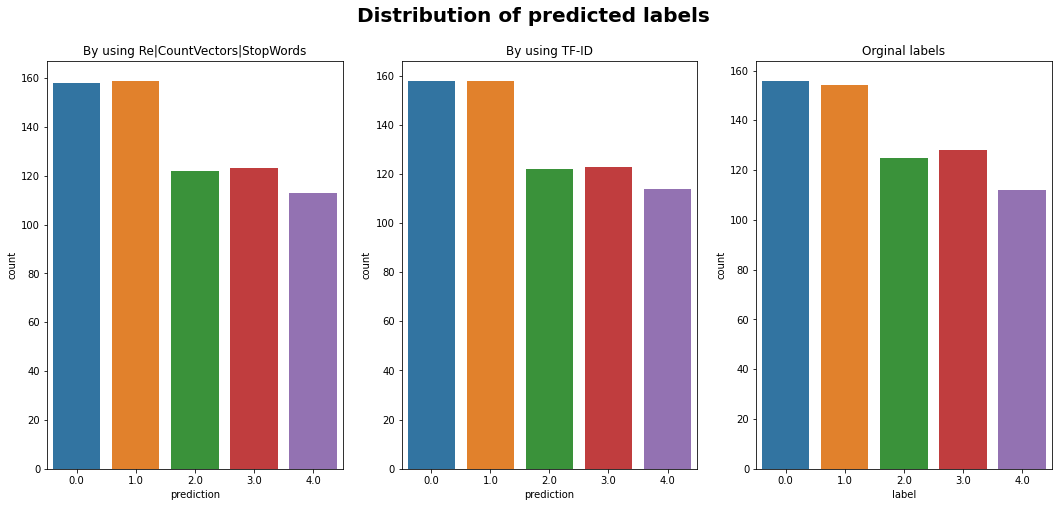

In [ ]:
fig,axes=plt.subplots(1,3,figsize=(18,7.5),sharex=True)
fig.suptitle("Distribution of predicted labels",size=20,weight='bold')
sns.countplot(ax=axes[0],data=pred_df,x='prediction')
axes[0].set_title("By using Re|CountVectors|StopWords")
sns.countplot(ax=axes[1],data=pred_df_TF,x='prediction')
axes[1].set_title("By using TF-ID")
sns.countplot(ax=axes[2],data=pred_df_TF,x='label')
axes[2].set_title("Orginal labels")
plt.show()

##Tunning the model

###Grid Search

In [ ]:
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
             .addGrid(lr.maxIter, [10, 20, 50]) #Number of iterations
             .build())

### Cross validation

In [ ]:
tunner = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)

###Training

In [ ]:
model_verion_1 = tunner.fit(trainingData)
predictions = model_verion_1.transform(testData)

###Evaluating

In [ ]:
evaluator.evaluate(predictions)

0.9747361208010044

In [ ]:
tunned_preds=predictions.toPandas()

In [ ]:
tunned_preds[:2]

,category,text,words,filtered,features,label,rawPrediction,probability,prediction
0,business,ad sales boost time warner profit quarterly pr...,"[ad, sales, boost, time, warner, profit, quart...","[ad, sales, boost, time, warner, profit, quart...","(18.0, 12.0, 10.0, 8.0, 7.0, 4.0, 7.0, 5.0, 3....",1.0,"[-0.3054029491941147, 5.743274595896988, -0.06...","[0.002239923336760231, 0.9487251971547862, 0.0...",1.0
1,business,amex shares up on spin-off news shares in amer...,"[amex, shares, up, on, spin, off, news, shares...","[amex, shares, up, on, spin, off, news, shares...","(4.0, 4.0, 3.0, 5.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",1.0,"[0.0494493928543594, 3.3881275906335904, -0.11...","[0.031252878464942055, 0.8807639717796664, 0.0...",1.0


##Analysing the predicitons

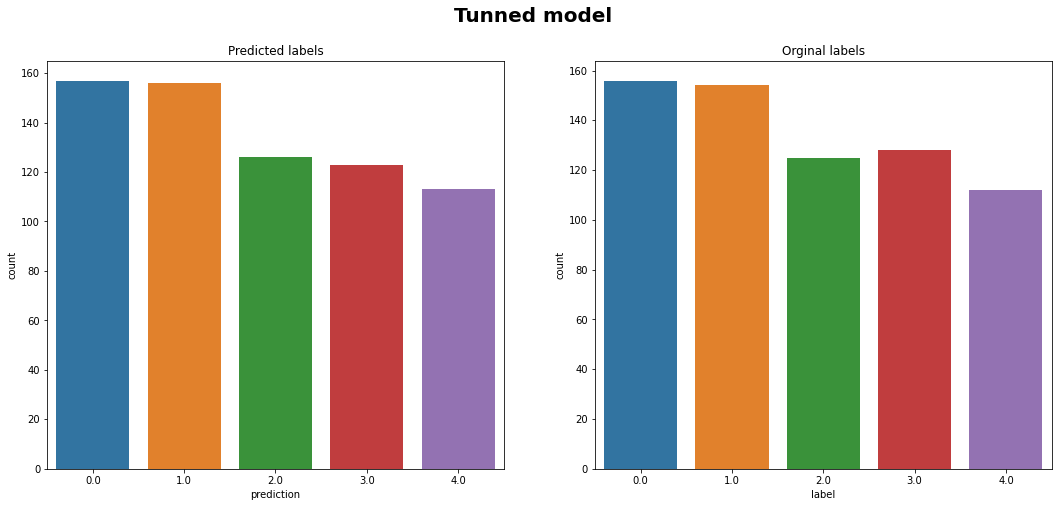

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(18,7.5),sharex=True)
fig.suptitle("Tunned model",size=20,weight='bold')
sns.countplot(ax=axes[0],data=tunned_preds,x='prediction')
axes[0].set_title("Predicted labels")
sns.countplot(ax=axes[1],data=tunned_preds,x='label')
axes[1].set_title("Orginal labels")
plt.show()